#Imports,reading data and checking correlation

##importing libraries, reading data

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
from statsmodels.compat import lzip
import statsmodels.formula.api as sm
import statsmodels.stats.stattools as st
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')
#change directory and show files in it 
import os
os.chdir("/content/drive/MyDrive/data for project ca683")

Mounted at /content/drive


In [ ]:
df = pd.read_csv('Accidents0515.csv')

## checking correlation between features and Accident severity (label)

In [ ]:
corr = df.corr()['Accident_Severity']

In [ ]:
corr[corr.values>.01]

Location_Easting_OSGR                          0.016804
Longitude                                      0.017292
Accident_Severity                              1.000000
Number_of_Vehicles                             0.074930
1st_Road_Class                                 0.011923
Junction_Detail                                0.045896
Junction_Control                               0.068979
2nd_Road_Class                                 0.064740
2nd_Road_Number                                0.025432
Weather_Conditions                             0.021672
Did_Police_Officer_Attend_Scene_of_Accident    0.115559
Name: Accident_Severity, dtype: float64

In [ ]:
corr[corr.values<-.03]

Location_Northing_OSGR       -0.032726
Latitude                     -0.032694
Police_Force                 -0.036083
Number_of_Casualties         -0.084122
Local_Authority_(District)   -0.036683
Road_Type                    -0.038998
Speed_limit                  -0.080647
Light_Conditions             -0.063286
Urban_or_Rural_Area          -0.083913
Name: Accident_Severity, dtype: float64

#DNN Iteration 1 - Features: 'Weather_Conditions','Speed_limit'

##Features

###Seleceting Features, checking correlation between them, cleaning missing data

In [ ]:
df_features = df[['Weather_Conditions', 'Speed_limit', 'Accident_Severity']]

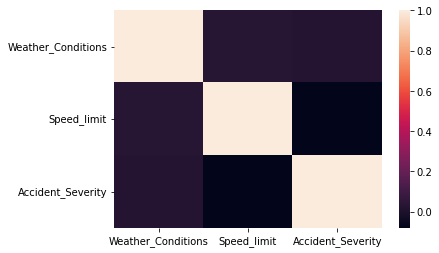

In [ ]:
#checking correlation between features
df_features.corr()
sns.heatmap(df_features.corr())

In [ ]:
#checking which values have missing data, note missing data is recorded as -1
df_features.min()

Weather_Conditions   -1
Speed_limit           0
Accident_Severity     1
dtype: int64

In [ ]:
#there are 161 accident that do not have recorded weather conditions, will drop these
df_features['Weather_Conditions'][df_features['Weather_Conditions']==-1].count()

161

In [ ]:
#removing all rows with (missing) data
df_features = df_features[df_features['Weather_Conditions']!=-1]
df_features = df_features[df_features['Speed_limit']!=0]

In [ ]:
#bucketising weather condtion into 2 bins
df_features['Weather_Conditions'] = df_features['Weather_Conditions'].replace(1,0)
df_features['Weather_Conditions'] = df_features['Weather_Conditions'].replace(4,0)
df_features['Weather_Conditions'] = df_features['Weather_Conditions'].replace(5,0)
df_features['Weather_Conditions'] = df_features['Weather_Conditions'].replace(7,0)
df_features['Weather_Conditions']= df_features['Weather_Conditions'].replace(2,1)
df_features['Weather_Conditions']= df_features['Weather_Conditions'].replace(3,1)
df_features['Weather_Conditions'] = df_features['Weather_Conditions'].replace(6,1)
df_features['Weather_Conditions'] = df_features['Weather_Conditions'].replace(8,1)
df_features['Weather_Conditions'] = df_features['Weather_Conditions'].replace(9,1)

In [ ]:
df_features['Weather_Conditions'].unique()

array([1, 0])

### Cleaning Label (accident severity) so that there are 2 classes instead of 3

In [ ]:
#check count for each level of accident deverity
df_features['Accident_Severity'].value_counts()

3    1515429
2     242067
1      22995
Name: Accident_Severity, dtype: int64

In [ ]:
#replace all accident severities where severiry is 2 or 3 and group them into 1 bucket (non-fatal)
df_features['Accident_Severity'] = df_features['Accident_Severity'].replace(2,0)
df_features['Accident_Severity'] = df_features['Accident_Severity'].replace(3,0)

In [ ]:
#create 2 dataframe, 1 for each class, and print the size each
class_1 = df_features[df_features['Accident_Severity'] == 1]
class_0 = df_features[df_features['Accident_Severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 22995
class 0 (non-fatal): 1757496


###Accounting for imbalance in the dataset by undersampling

In [ ]:
#get the length of the dataset for each class/label
class_count_0, class_count_1 = df_features['Accident_Severity'].value_counts()

In [ ]:
#undersampling of class 0 to balance the count of data for each class/label
class_0_under = class_0.sample(class_count_1)
df_features_under = pd.concat([class_0_under, class_1], axis=0)

In [ ]:
#print the size of the new dataset for each class/label after undersampling
class_1 = df_features_under[df_features_under['Accident_Severity'] == 1]
class_0 = df_features_under[df_features_under['Accident_Severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 22995
class 0 (non-fatal): 22995


###splitting the dataset in training and test datasets

In [ ]:
#splitting the dataset into training and test sets
train_features_under, test_features_under = train_test_split(df_features_under, test_size=0.25)

In [ ]:
#pop out the label column from the train and test undersampled datasets
train_label_under = train_features_under.pop('Accident_Severity')
test_label_under = test_features_under.pop('Accident_Severity')

## DNN Classifier

###defining input function, creating classifier, training classifer

In [ ]:
def input_fn(features, labels, training=True, batch_size=344):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

In [ ]:
# creating a tensorflow Feature column list
my_feature_columns = []
for key in train_features_under.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
my_feature_columns

[NumericColumn(key='Weather_Conditions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Speed_limit', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 2 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp4a2q8as5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
classifier.train(input_fn=lambda: input_fn(train_features_under, train_label_under, training=True),steps=5000)
# We include a lambda to avoid creating an inner function 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp4a2q8as5/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6943212, step = 0
INFO:tensorflow:global_step/sec: 300.194
INFO:tensorflow:loss = 0.6895874, step = 100 (0.339 sec)
INFO:tensorflow:global_step/sec: 368.563
INFO:tensorflow:loss = 0.6780583, step = 200 (0.270 sec)
INFO:tensorflow:global_step/sec: 360.419
INFO:tensorflow:loss = 0.68036836, step = 300 (0.275 sec)
INFO:tensorflow:global_step/sec: 378.702
INFO:tensorflow:loss = 0.6815298, step = 400 (0.268 sec)
INFO:tensorflow:global_step/sec: 372.512
INFO:tensorflow:loss = 0.6789994, step = 500 (0.267 sec)
INFO:

###Evaluating Classifier

In [ ]:
#determine the accurracy of th classifier
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test_features_under, test_label_under, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-04-03T22:04:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4a2q8as5/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.73896s
INFO:tensorflow:Finished evaluation at 2022-04-03-22:04:10
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.6682032, accuracy_baseline = 0.5058271, auc = 0.6837756, auc_precision_recall = 0.63947046, average_loss = 0.6663864, global_step = 5000, label/mean = 0.4941729, loss = 0.66651005, precision = 0.66175705, prediction/mean = 0.5293326, recall = 0.6721225
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmp4a2q8as5/model.ckpt-5000

Test set accuracy: 0.668



In [ ]:
#create predictions list for all test set
predictions_under = list(classifier.predict(input_fn=lambda: input_fn(test_features_under, test_label_under, training=False)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4a2q8as5/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
#create a dataframe of predictions for test set
df_predictions = pd.DataFrame(predictions_under)

###Plot of Results

In [ ]:
#add the actual matches to the prediciton dataframe
df_predictions['actual label']=test_label_under.values

In [ ]:
#add the class predicitons from the DNN to the dataframe
df_predictions['predicted label']=pd.DataFrame.from_records(df_predictions['class_ids'])

In [ ]:
#add a binary column to show if the dnn predictions were correct
df_predictions['match?']=df_predictions['predicted label']-df_predictions['actual label']
df_predictions['match?']=df_predictions['match?'].replace(0,'match')
df_predictions['match?']=df_predictions['match?'].replace(-1,'not match')
df_predictions['match?']=df_predictions['match?'].replace(1,'not match')

In [ ]:
#view the prdictions dataframe
a=df_predictions[df_predictions['actual label']==1]
a

,logits,logistic,probabilities,class_ids,classes,all_class_ids,all_classes,actual label,predicted label,match?
3,[0.34476355],[0.5853472],"[0.41465282, 0.5853472]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
4,[-0.093798846],[0.47656748],"[0.52343255, 0.47656745]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
7,[0.3135307],[0.5777468],"[0.42225322, 0.57774687]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
10,[-0.093798846],[0.47656748],"[0.52343255, 0.47656745]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
12,[0.34476355],[0.5853472],"[0.41465282, 0.5853472]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
...,...,...,...,...,...,...,...,...,...,...
11489,[-0.062566966],[0.48436338],"[0.5156366, 0.48436332]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
11492,[-0.062566966],[0.48436338],"[0.5156366, 0.48436332]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
11493,[0.34476355],[0.5853472],"[0.41465282, 0.5853472]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
11494,[0.34476355],[0.5853472],"[0.41465282, 0.5853472]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match


In [ ]:
#create a new dataframe showing only the correct predictions
correct_predictions = df_predictions[df_predictions['match?']=='match']
#get the count of the correct predctions for eah label
correct_pred_count_label_0 , correct_pred_count_label_1 = correct_predictions['predicted label'].value_counts()
#get the actual label count for each label
actual_count_label_0 , actual_count_label_1 = df_predictions['actual label'].value_counts()

In [ ]:
#get the accuracy of each labels predictions
accuracy_label_0,accuracy_label_1 = correct_pred_count_label_0/actual_count_label_0 , correct_pred_count_label_1/actual_count_label_1
accuracy=accuracy_label_0*100,accuracy_label_1*100
accuracy=pd.Series(accuracy)
print('Accuracy of label 0 (non-fatal): ', accuracy_label_0, '\nAccuracy of label 1 (fatal): ', accuracy_label_1)

Accuracy of label 0 (non-fatal):  0.6643741403026134 
Accuracy of label 1 (fatal):  0.6721224920802534


Text(0.5, 1.0, 'percentage accuracy for each class/label')

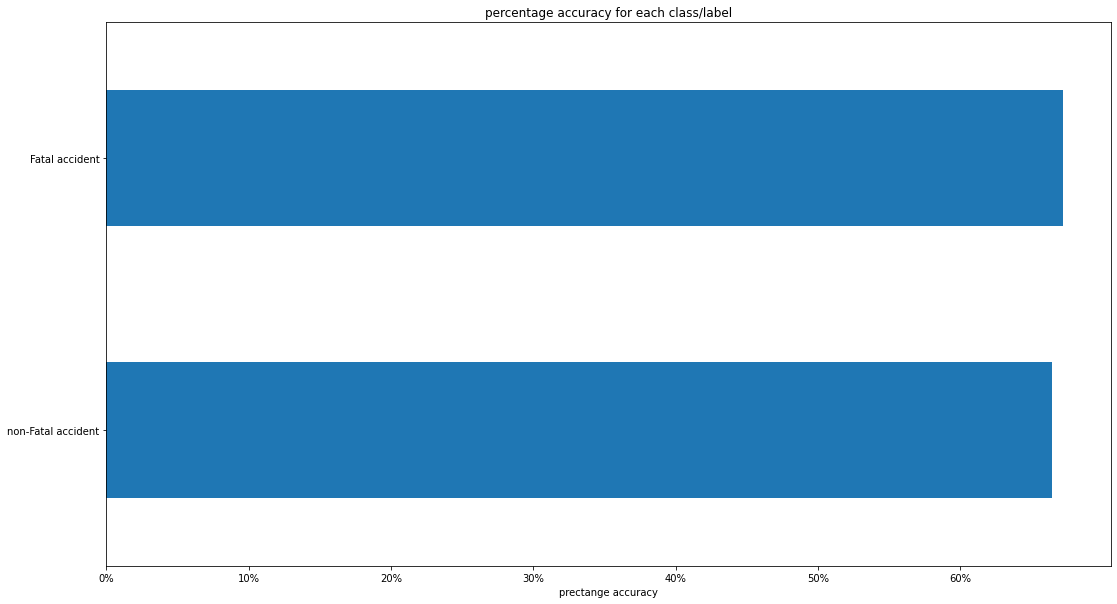

In [ ]:
#plot the accuracy of each labels predictions
fig, axes = plt.subplots(figsize=(18, 10))
accuracy.plot(kind='barh')
plt.yticks((0,1), ('non-Fatal accident', 'Fatal accident'))
plt.xticks((0,10,20,30,40,50,60), ('0%', '10%','20%','30%','40%','50%','60%'))
plt.xlabel('prectange accuracy')
plt.title('percentage accuracy for each class/label')

#Iteration 2 - 'Weather_Conditions', 'Light_Conditions','Speed_limit'

##Features

###Seleceting Features, checking correlation between them, cleaning missing data

In [ ]:
df_features = df[['Weather_Conditions', 'Light_Conditions','Speed_limit','Accident_Severity']]

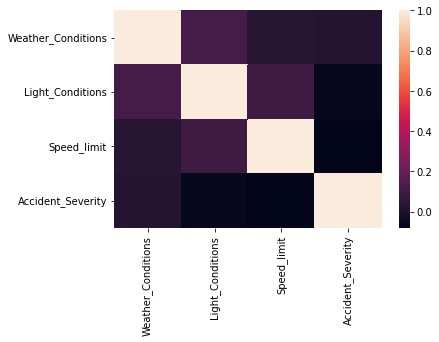

In [ ]:
#checking correlation between features
df_features.corr()
sns.heatmap(df_features.corr())

In [ ]:
#checking which values have missing data, note missing data is recorded as -1
df_features.min()

Weather_Conditions   -1
Light_Conditions      1
Speed_limit           0
Accident_Severity     1
dtype: int64

In [ ]:
#there are 161 accident that do not have recorded weather conditions, will drop these
df_features['Weather_Conditions'][df_features['Weather_Conditions']==-1].count()

161

In [ ]:
#removing all rows with (missing) data
df_features = df_features[df_features['Weather_Conditions']!=-1]
df_features = df_features[df_features['Speed_limit']!=0]

df_features.count()

### Cleaning Label (accident severity) so that there are 2 classes instead of 3

In [ ]:
#check count for each level of accident deverity
df_features['Accident_Severity'].value_counts()

3    1515429
2     242067
1      22995
Name: Accident_Severity, dtype: int64

In [ ]:
#replace all accident severities where severiry is 2 or 3 and group them into 1 bucket (non-fatal)
df_features['Accident_Severity'] = df_features['Accident_Severity'].replace(2,0)
df_features['Accident_Severity'] = df_features['Accident_Severity'].replace(3,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#create 2 dataframe, 1 for each class, and print the size each
class_1 = df_features[df_features['Accident_Severity'] == 1]
class_0 = df_features[df_features['Accident_Severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 22995
class 0 (non-fatal): 1757496


###Accounting for imbalance in the dataset by undersampling

In [ ]:
#get the length of the dataset for each class/label
class_count_0, class_count_1 = df_features['Accident_Severity'].value_counts()

In [ ]:
#undersampling of class 0 to balance the count of data for each class/label
class_0_under = class_0.sample(class_count_1)
df_features_under = pd.concat([class_0_under, class_1], axis=0)

In [ ]:
#print the size of the new dataset for each class/label after undersampling
class_1 = df_features_under[df_features_under['Accident_Severity'] == 1]
class_0 = df_features_under[df_features_under['Accident_Severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 22995
class 0 (non-fatal): 22995


###splitting the dataset in training and test datasets

In [ ]:
#splitting the dataset into training and test sets
train_features_under, test_features_under = train_test_split(df_features_under, test_size=0.25)

In [ ]:
#pop out the label column from the train and test undersampled datasets
train_label_under = train_features_under.pop('Accident_Severity')
test_label_under = test_features_under.pop('Accident_Severity')

## DNN Classifier

###defining input function, creating classifier, training classifer

In [ ]:
def input_fn(features, labels, training=True, batch_size=344):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

In [ ]:
# creating a tensorflow Feature column list
my_feature_columns = []
for key in train_features_under.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
my_feature_columns

[NumericColumn(key='Weather_Conditions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Light_Conditions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Speed_limit', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 2 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpfthq6098', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
classifier.train(input_fn=lambda: input_fn(train_features_under, train_label_under, training=True),steps=1000)
# We include a lambda to avoid creating an inner function previously

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpfthq6098/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 7.4784856, step = 0
INFO:tensorflow:global_step/sec: 264.515
INFO:tensorflow:loss = 2.7558503, step = 100 (0.382 sec)
INFO:tensorflow:global_step/sec: 337.571
INFO:tensorflow:loss = 1.1053634, step = 200 (0.298 sec)
INFO:tensorflow:global_step/sec: 328.121
INFO:tensorflow:loss = 0.671809, step = 300 (0.303 sec)
INFO:tensorflow:global_step/sec: 339.006
INFO:tensorflow:loss = 0.689614, step = 400 (0.296 sec)
INFO:tensorflow:global_step/sec: 340.968
INFO:tensorflow:loss = 0.6877387, step = 500 (0.292 sec)
INFO:ten

###Evaluating Classifier

In [ ]:
#determine the accurracy of th classifier
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test_features_under, test_label_under, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-04-03T20:54:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpfthq6098/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.81262s
INFO:tensorflow:Finished evaluation at 2022-04-03-20:54:19
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.5281788, accuracy_baseline = 0.50321794, auc = 0.6235275, auc_precision_recall = 0.6014335, average_loss = 0.67574084, global_step = 1000, label/mean = 0.50321794, loss = 0.67573535, precision = 0.5206877, prediction/mean = 0.53674823, recall = 0.7851711
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpfthq6098/model.ckpt-1000

Test set accuracy: 0.528



In [ ]:
#create predictions list for all test set
predictions_under = list(classifier.predict(input_fn=lambda: input_fn(test_features_under, test_label_under, training=False)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpfthq6098/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
#create a dataframe of predictions for test set
df_predictions = pd.DataFrame(predictions_under)

###Plot of Results

In [ ]:
#add the actual matches to the prediciton dataframe
df_predictions['actual label']=test_label_under.values

In [ ]:
#add the class predicitons from the DNN to the dataframe
df_predictions['predicted label']=pd.DataFrame.from_records(df_predictions['class_ids'])

In [ ]:
#add a binary column to show if the dnn predictions were correct
df_predictions['match?']=df_predictions['predicted label']-df_predictions['actual label']
df_predictions['match?']=df_predictions['match?'].replace(0,'match')
df_predictions['match?']=df_predictions['match?'].replace(-1,'not match')
df_predictions['match?']=df_predictions['match?'].replace(1,'not match')

In [ ]:
#view the prdictions dataframe
df_predictions.head()

,logits,logistic,probabilities,class_ids,classes,all_class_ids,all_classes,actual label,predicted label,match?
0,[0.18222898],[0.5454316],"[0.45456845, 0.5454316]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match
1,[0.6473179],[0.6564058],"[0.34359422, 0.6564058]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match
2,[0.06222656],[0.5155516],"[0.48444834, 0.51555157]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match
3,[0.027198788],[0.5067993],"[0.49320072, 0.5067993]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
4,[0.027198788],[0.5067993],"[0.49320072, 0.5067993]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match


In [ ]:
#create a new dataframe showing only the correct predictions
correct_predictions = df_predictions[df_predictions['match?']=='match']
#get the count of the correct predctions for eah label
correct_pred_count_label_0 , correct_pred_count_label_1 = correct_predictions['predicted label'].value_counts()
#get the actual label count for each label
actual_count_label_0 , actual_count_label_1 = df_predictions['actual label'].value_counts()

In [ ]:
#get the accuracy of each labels predictions
accuracy_label_0,accuracy_label_1 = correct_pred_count_label_0/actual_count_label_0 , correct_pred_count_label_1/actual_count_label_1
accuracy=accuracy_label_0*100,accuracy_label_1*100
accuracy=pd.Series(accuracy)
print('Accuracy of label 0 (non-fatal): ', accuracy_label_0, '\nAccuracy of label 1 (fatal): ', accuracy_label_1)

Accuracy of label 0 (non-fatal):  0.785171102661597 
Accuracy of label 1 (fatal):  0.26785714285714285


Text(0.5, 1.0, 'percentage accuracy for each class/label')

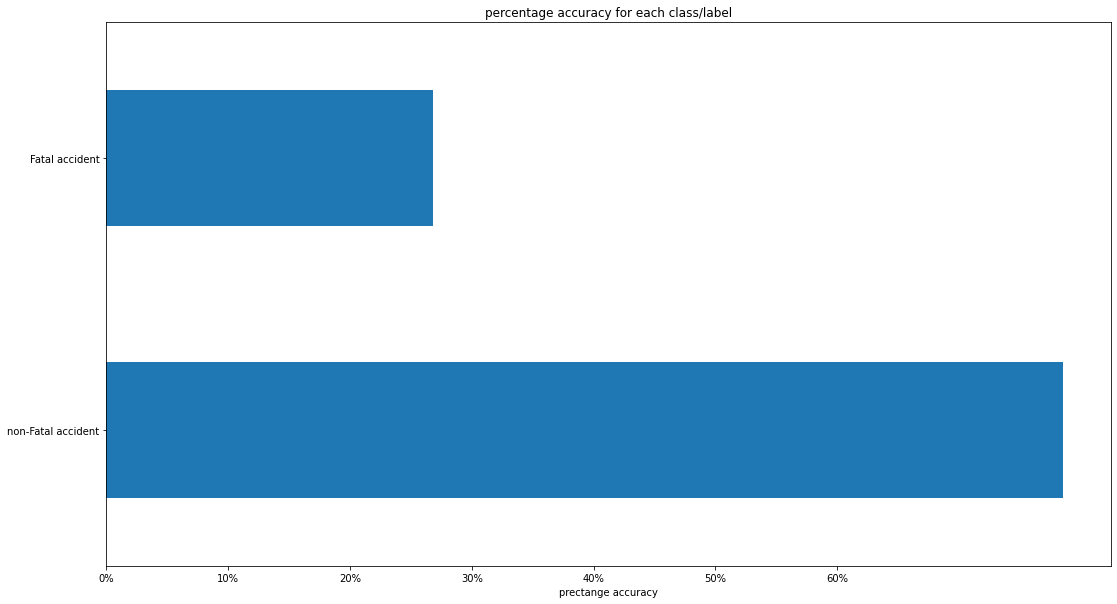

In [ ]:
#plot the accuracy of each labels predictions
fig, axes = plt.subplots(figsize=(18, 10))
accuracy.plot(kind='barh')
plt.yticks((0,1), ('non-Fatal accident', 'Fatal accident'))
plt.xticks((0,10,20,30,40,50,60), ('0%', '10%','20%','30%','40%','50%','60%'))
plt.xlabel('prectange accuracy')
plt.title('percentage accuracy for each class/label')

#Iteration 3 - 'Weather_Conditions', 'Local_Authority_(District)','Speed_limit'

##Features

###Seleceting Features, checking correlation between them, cleaning missing data

In [ ]:
df_features = df[['Weather_Conditions', 'Local_Authority_(District)','Speed_limit','Accident_Severity']]
df_features = df_features.rename(columns={'Local_Authority_(District)':'district'})

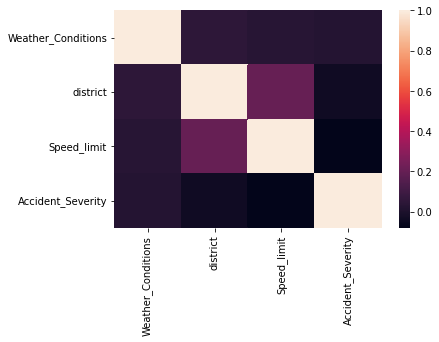

In [ ]:
#checking correlation between features
df_features.corr()
sns.heatmap(df_features.corr())

In [ ]:
#checking which values have missing data, note missing data is recorded as -1
df_features.min()

Weather_Conditions   -1
district              1
Speed_limit           0
Accident_Severity     1
dtype: int64

In [ ]:
#there are 161 accident that do not have recorded weather conditions, will drop these
df_features['Weather_Conditions'][df_features['Weather_Conditions']==-1].count()

161

In [ ]:
#removing all rows with (missing) data
df_features = df_features[df_features['Weather_Conditions']!=-1]
df_features = df_features[df_features['Speed_limit']!=0]

df_features.count()

### Cleaning Label (accident severity) so that there are 2 classes instead of 3

In [ ]:
#check count for each level of accident deverity
df_features['Accident_Severity'].value_counts()

3    1515429
2     242067
1      22995
Name: Accident_Severity, dtype: int64

In [ ]:
#replace all accident severities where severiry is 2 or 3 and group them into 1 bucket (non-fatal)
df_features['Accident_Severity'] = df_features['Accident_Severity'].replace(2,0)
df_features['Accident_Severity'] = df_features['Accident_Severity'].replace(3,0)

In [ ]:
#create 2 dataframe, 1 for each class, and print the size each
class_1 = df_features[df_features['Accident_Severity'] == 1]
class_0 = df_features[df_features['Accident_Severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 22995
class 0 (non-fatal): 1757496


###Accounting for imbalance in the dataset by undersampling

In [ ]:
#get the length of the dataset for each class/label
class_count_0, class_count_1 = df_features['Accident_Severity'].value_counts()

In [ ]:
#undersampling of class 0 to balance the count of data for each class/label
class_0_under = class_0.sample(class_count_1)
df_features_under = pd.concat([class_0_under, class_1], axis=0)

In [ ]:
#print the size of the new dataset for each class/label after undersampling
class_1 = df_features_under[df_features_under['Accident_Severity'] == 1]
class_0 = df_features_under[df_features_under['Accident_Severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 22995
class 0 (non-fatal): 22995


###splitting the dataset in training and test datasets

In [ ]:
#splitting the dataset into training and test sets
train_features_under, test_features_under = train_test_split(df_features_under, test_size=0.25)

In [ ]:
#pop out the label column from the train and test undersampled datasets
train_label_under = train_features_under.pop('Accident_Severity')
test_label_under = test_features_under.pop('Accident_Severity')

## DNN Classifier

###defining input function, creating classifier, training classifer

In [ ]:
def input_fn(features, labels, training=True, batch_size=344):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

In [ ]:
# creating a tensorflow Feature column list
my_feature_columns = []
for key in train_features_under.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
my_feature_columns

[NumericColumn(key='Weather_Conditions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='district', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Speed_limit', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 2 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp9l2p86q1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
classifier.train(input_fn=lambda: input_fn(train_features_under, train_label_under, training=True),steps=5000)
# We include a lambda to avoid creating an inner function previously

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp9l2p86q1/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5000...
INFO:tensorflow:Saving checkpoints for 5000 into /tmp/tmp9l2p86q1/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5000...
INFO:tensorflow:loss = 0.6779279, step = 5000
INFO:tensorflow:global_step/sec: 292.985
INFO:tensorflow:loss = 0.66504884, step = 5100 (0.345 sec)
INFO:tensorflow:global_step/sec: 367.576
INFO:tensorflow:loss = 0.67332464, step = 5200 (0.271 sec)
INFO:tensorflow:global_step/sec: 394.708
INFO:tensorflow:loss = 0.67707276, step = 5300 (0.254 sec)
INFO:tensorflow:global_step/sec: 372.458
INFO:tensorflow:loss = 0.6867147, step = 5400 (0.270 sec)
INFO:tenso

###Evaluating Classifier

In [ ]:
#determine the accurracy of th classifier
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test_features_under, test_label_under, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-03-26T16:25:04
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp9l2p86q1/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.67605s
INFO:tensorflow:Finished evaluation at 2022-03-26-16:25:05
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.6221082, accuracy_baseline = 0.5043486, auc = 0.6590688, auc_precision_recall = 0.63611317, average_loss = 0.6592431, global_step = 10000, label/mean = 0.5043486, loss = 0.65972984, precision = 0.6118806, prediction/mean = 0.5292163, recall = 0.68563545
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: /tmp/tmp9l2p86q1/model.ckpt-10000

Test set accuracy: 0.622



In [ ]:
#create predictions list for all test set
predictions_under = list(classifier.predict(input_fn=lambda: input_fn(test_features_under, test_label_under, training=False)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp9l2p86q1/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
#create a dataframe of predictions for test set
df_predictions = pd.DataFrame(predictions_under)

###Plot of Results

In [ ]:
#add the actual matches to the prediciton dataframe
df_predictions['actual label']=test_label_under.values

In [ ]:
#add the class predicitons from the DNN to the dataframe
df_predictions['predicted label']=pd.DataFrame.from_records(df_predictions['class_ids'])

In [ ]:
#add a binary column to show if the dnn predictions were correct
df_predictions['match?']=df_predictions['predicted label']-df_predictions['actual label']
df_predictions['match?']=df_predictions['match?'].replace(0,'match')
df_predictions['match?']=df_predictions['match?'].replace(-1,'not match')
df_predictions['match?']=df_predictions['match?'].replace(1,'not match')

In [ ]:
#view the prdictions dataframe
df_predictions.head()

,logits,logistic,probabilities,class_ids,classes,all_class_ids,all_classes,actual label,predicted label,match?
0,[-0.3391452],[0.41601714],"[0.5839829, 0.41601717]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
1,[0.64586884],[0.6560789],"[0.3439211, 0.65607893]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
2,[-1.0125974],[0.26647186],"[0.7335282, 0.26647183]",[0],[b'0'],"[0, 1]","[b'0', b'1']",0,0,match
3,[-1.023959],[0.26425695],"[0.73574305, 0.26425692]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
4,[0.11738118],[0.52931166],"[0.47068837, 0.52931166]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match


In [ ]:
#create a new dataframe showing only the correct predictions
correct_predictions = df_predictions[df_predictions['match?']=='match']
#get the count of the correct predctions for eah label
correct_pred_count_label_0 , correct_pred_count_label_1 = correct_predictions['predicted label'].value_counts()
#get the actual label count for each label
actual_count_label_0 , actual_count_label_1 = df_predictions['actual label'].value_counts()

In [ ]:
#get the accuracy of each labels predictions
accuracy_label_0,accuracy_label_1 = correct_pred_count_label_0/actual_count_label_0 , correct_pred_count_label_1/actual_count_label_1
accuracy=accuracy_label_0*100,accuracy_label_1*100
accuracy=pd.Series(accuracy)
print('Accuracy of label 0 (non-fatal): ', accuracy_label_0, '\nAccuracy of label 1 (fatal): ', accuracy_label_1)

Accuracy of label 0 (non-fatal):  0.6856354543886877 
Accuracy of label 1 (fatal):  0.5574662221442358


Text(0.5, 1.0, 'percentage accuracy for each class/label')

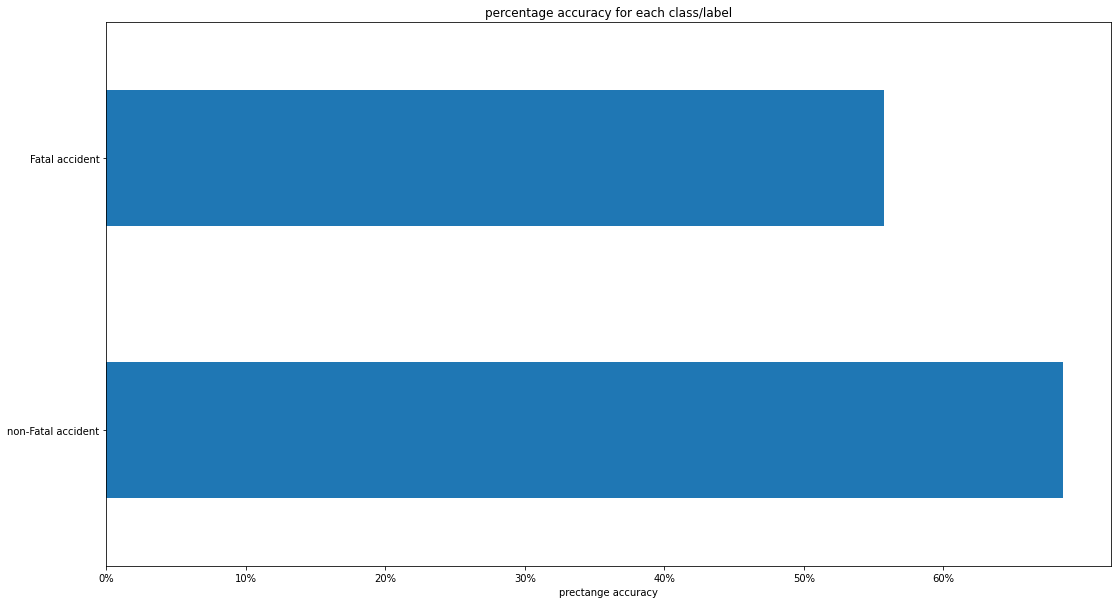

In [ ]:
#plot the accuracy of each labels predictions
fig, axes = plt.subplots(figsize=(18, 10))
accuracy.plot(kind='barh')
plt.yticks((0,1), ('non-Fatal accident', 'Fatal accident'))
plt.xticks((0,10,20,30,40,50,60), ('0%', '10%','20%','30%','40%','50%','60%'))
plt.xlabel('prectange accuracy')
plt.title('percentage accuracy for each class/label')

#Iteration 4 - 'Weather_Conditions','Speed_limit', 'Day_of_Week'

##Features

###Seleceting Features, checking correlation between them, cleaning missing data

In [ ]:
df_features = df[['Weather_Conditions','Speed_limit', 'Day_of_Week','Accident_Severity']]

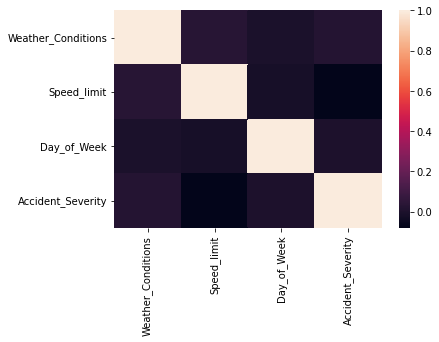

In [ ]:
#checking correlation between features
df_features.corr()
sns.heatmap(df_features.corr())

In [ ]:
#checking which values have missing data, note missing data is recorded as -1
df_features.min()

Weather_Conditions   -1
Speed_limit           0
Day_of_Week           1
Accident_Severity     1
dtype: int64

In [ ]:
#there are 161 accident that do not have recorded weather conditions, will drop these
df_features['Weather_Conditions'][df_features['Weather_Conditions']==-1].count()

161

In [ ]:
#removing all rows with (missing) data
df_features = df_features[df_features['Weather_Conditions']!=-1]
df_features = df_features[df_features['Speed_limit']!=0]

df_features.count()

### Cleaning Label (accident severity) so that there are 2 classes instead of 3

In [ ]:
#check count for each level of accident deverity
df_features['Accident_Severity'].value_counts()

3    1515429
2     242067
1      22995
Name: Accident_Severity, dtype: int64

In [ ]:
#replace all accident severities where severiry is 2 or 3 and group them into 1 bucket (non-fatal)
df_features['Accident_Severity'] = df_features['Accident_Severity'].replace(2,0)
df_features['Accident_Severity'] = df_features['Accident_Severity'].replace(3,0)

In [ ]:
#create 2 dataframe, 1 for each class, and print the size each
class_1 = df_features[df_features['Accident_Severity'] == 1]
class_0 = df_features[df_features['Accident_Severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 22995
class 0 (non-fatal): 1757496


###Accounting for imbalance in the dataset by undersampling

In [ ]:
#get the length of the dataset for each class/label
class_count_0, class_count_1 = df_features['Accident_Severity'].value_counts()

In [ ]:
#undersampling of class 0 to balance the count of data for each class/label
class_0_under = class_0.sample(class_count_1)
df_features_under = pd.concat([class_0_under, class_1], axis=0)

In [ ]:
#print the size of the new dataset for each class/label after undersampling
class_1 = df_features_under[df_features_under['Accident_Severity'] == 1]
class_0 = df_features_under[df_features_under['Accident_Severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 22995
class 0 (non-fatal): 22995


###splitting the dataset in training and test datasets

In [ ]:
#splitting the dataset into training and test sets
train_features_under, test_features_under = train_test_split(df_features_under, test_size=0.25)

In [ ]:
#pop out the label column from the train and test undersampled datasets
train_label_under = train_features_under.pop('Accident_Severity')
test_label_under = test_features_under.pop('Accident_Severity')

## DNN Classifier

###defining input function, creating classifier, training classifer

In [ ]:
def input_fn(features, labels, training=True, batch_size=344):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

In [ ]:
# creating a tensorflow Feature column list
my_feature_columns = []
for key in train_features_under.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
my_feature_columns

[NumericColumn(key='Weather_Conditions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Speed_limit', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Day_of_Week', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 2 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_dm3pyni', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
classifier.train(input_fn=lambda: input_fn(train_features_under, train_label_under, training=True),steps=2000)
# We include a lambda to avoid creating an inner function 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_dm3pyni/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2000...
INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp_dm3pyni/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2000...
INFO:tensorflow:loss = 0.64827144, step = 2000
INFO:tensorflow:global_step/sec: 367.664
INFO:tensorflow:loss = 0.6568535, step = 2100 (0.277 sec)
INFO:tensorflow:global_step/sec: 475.35
INFO:tensorflow:loss = 0.67439246, step = 2200 (0.207 sec)
INFO:tensorflow:global_step/sec: 493.846
INFO:tensorflow:loss = 0.64421374, step = 2300 (0.205 sec)
INFO:tensorflow:global_step/sec: 469.718
INFO:tensorflow:loss = 0.65210176, step = 2400 (0.212 sec)
INFO:tenso

###Evaluating Classifier

In [ ]:
#determine the accurracy of th classifier
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test_features_under, test_label_under, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-03-26T16:41:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_dm3pyni/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.52482s
INFO:tensorflow:Finished evaluation at 2022-03-26-16:41:13
INFO:tensorflow:Saving dict for global step 4000: accuracy = 0.6267177, accuracy_baseline = 0.5021743, auc = 0.6647515, auc_precision_recall = 0.64488995, average_loss = 0.6544166, global_step = 4000, label/mean = 0.4978257, loss = 0.6540678, precision = 0.6124019, prediction/mean = 0.5253167, recall = 0.6815164
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4000: /tmp/tmp_dm3pyni/model.ckpt-4000

Test set accuracy: 0.627



In [ ]:
#create predictions list for all test set
predictions_under = list(classifier.predict(input_fn=lambda: input_fn(test_features_under, test_label_under, training=False)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_dm3pyni/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
#create a dataframe of predictions for test set
df_predictions = pd.DataFrame(predictions_under)

###Plot of Results

In [ ]:
#add the actual matches to the prediciton dataframe
df_predictions['actual label']=test_label_under.values

In [ ]:
#add the class predicitons from the DNN to the dataframe
df_predictions['predicted label']=pd.DataFrame.from_records(df_predictions['class_ids'])

In [ ]:
#add a binary column to show if the dnn predictions were correct
df_predictions['match?']=df_predictions['predicted label']-df_predictions['actual label']
df_predictions['match?']=df_predictions['match?'].replace(0,'match')
df_predictions['match?']=df_predictions['match?'].replace(-1,'not match')
df_predictions['match?']=df_predictions['match?'].replace(1,'not match')

In [ ]:
#view the prdictions dataframe
df_predictions.head()

,logits,logistic,probabilities,class_ids,classes,all_class_ids,all_classes,actual label,predicted label,match?
0,[-0.28904212],[0.4282384],"[0.5717616, 0.42823836]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
1,[0.6930474],[0.66664445],"[0.33335552, 0.6666445]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match
2,[-0.5142714],[0.37419277],"[0.6258072, 0.3741927]",[0],[b'0'],"[0, 1]","[b'0', b'1']",0,0,match
3,[-0.28904212],[0.4282384],"[0.5717616, 0.42823836]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
4,[-0.18493474],[0.45389766],"[0.54610234, 0.45389763]",[0],[b'0'],"[0, 1]","[b'0', b'1']",0,0,match


In [ ]:
#create a new dataframe showing only the correct predictions
correct_predictions = df_predictions[df_predictions['match?']=='match']
#get the count of the correct predctions for eah label
correct_pred_count_label_0 , correct_pred_count_label_1 = correct_predictions['predicted label'].value_counts()
#get the actual label count for each label
actual_count_label_0 , actual_count_label_1 = df_predictions['actual label'].value_counts()

In [ ]:
#get the accuracy of each labels predictions
accuracy_label_0,accuracy_label_1 = correct_pred_count_label_0/actual_count_label_0 , correct_pred_count_label_1/actual_count_label_1
accuracy=accuracy_label_0*100,accuracy_label_1*100
accuracy=pd.Series(accuracy)
print('Accuracy of label 0 (non-fatal): ', accuracy_label_0, '\nAccuracy of label 1 (fatal): ', accuracy_label_1)

Accuracy of label 0 (non-fatal):  0.6756148250779356 
Accuracy of label 1 (fatal):  0.577393431167016


Text(0.5, 1.0, 'percentage accuracy for each class/label')

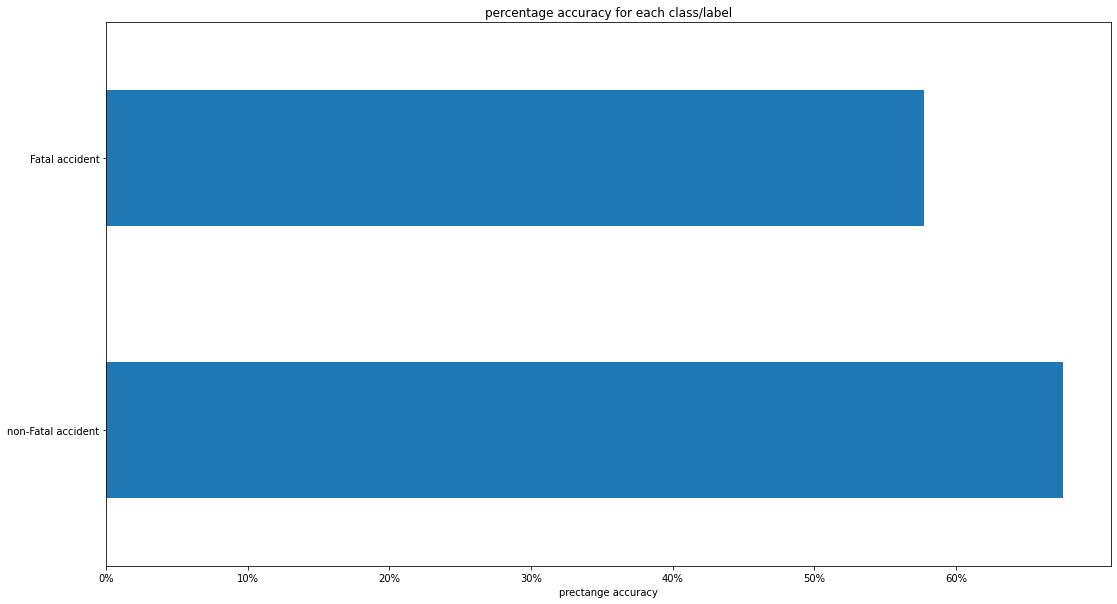

In [ ]:
#plot the accuracy of each labels predictions
fig, axes = plt.subplots(figsize=(18, 10))
accuracy.plot(kind='barh')
plt.yticks((0,1), ('non-Fatal accident', 'Fatal accident'))
plt.xticks((0,10,20,30,40,50,60), ('0%', '10%','20%','30%','40%','50%','60%'))
plt.xlabel('prectange accuracy')
plt.title('percentage accuracy for each class/label')

#Iteration 5 - 'Weather_Conditions'

##Features

###Seleceting Features, checking correlation between them, cleaning missing data

In [ ]:
df_features = df[['Weather_Conditions','Accident_Severity']]

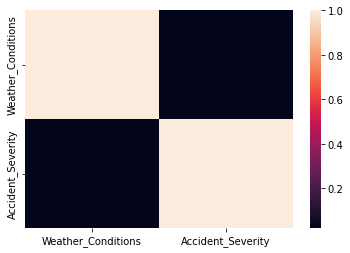

In [ ]:
#checking correlation between features
df_features.corr()
sns.heatmap(df_features.corr())

In [ ]:
#checking which values have missing data, note missing data is recorded as -1
df_features.min()

Weather_Conditions   -1
Accident_Severity     1
dtype: int64

In [ ]:
#there are 161 accident that do not have recorded weather conditions, will drop these
df_features['Weather_Conditions'][df_features['Weather_Conditions']==-1].count()

161

In [ ]:
#removing all rows with (missing) data
df_features = df_features[df_features['Weather_Conditions']!=-1]
#df_features = df_features[df_features['Speed_limit']!=0]

df_features.count()

### Cleaning Label (accident severity) so that there are 2 classes instead of 3

In [ ]:
#check count for each level of accident deverity
df_features['Accident_Severity'].value_counts()

3    1515430
2     242067
1      22995
Name: Accident_Severity, dtype: int64

In [ ]:
#replace all accident severities where severiry is 2 or 3 and group them into 1 bucket (non-fatal)
df_features['Accident_Severity'] = df_features['Accident_Severity'].replace(2,0)
df_features['Accident_Severity'] = df_features['Accident_Severity'].replace(3,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#create 2 dataframe, 1 for each class, and print the size each
class_1 = df_features[df_features['Accident_Severity'] == 1]
class_0 = df_features[df_features['Accident_Severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 22995
class 0 (non-fatal): 1757497


###Accounting for imbalance in the dataset by undersampling

In [ ]:
#get the length of the dataset for each class/label
class_count_0, class_count_1 = df_features['Accident_Severity'].value_counts()

In [ ]:
#undersampling of class 0 to balance the count of data for each class/label
class_0_under = class_0.sample(class_count_1)
df_features_under = pd.concat([class_0_under, class_1], axis=0)

In [ ]:
#print the size of the new dataset for each class/label after undersampling
class_1 = df_features_under[df_features_under['Accident_Severity'] == 1]
class_0 = df_features_under[df_features_under['Accident_Severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 22995
class 0 (non-fatal): 22995


###splitting the dataset in training and test datasets

In [ ]:
#splitting the dataset into training and test sets
train_features_under, test_features_under = train_test_split(df_features_under, test_size=0.25)

In [ ]:
#pop out the label column from the train and test undersampled datasets
train_label_under = train_features_under.pop('Accident_Severity')
test_label_under = test_features_under.pop('Accident_Severity')

## DNN Classifier

###defining input function, creating classifier, training classifer

In [ ]:
def input_fn(features, labels, training=True, batch_size=344):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

In [ ]:
# creating a tensorflow Feature column list
my_feature_columns = []
for key in train_features_under.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
my_feature_columns

[NumericColumn(key='Weather_Conditions', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 2 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp1kkz0041', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
classifier.train(input_fn=lambda: input_fn(train_features_under, train_label_under, training=True),steps=5000)
# We include a lambda to avoid creating an inner function 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp1kkz0041/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.70474756, step = 0
INFO:tensorflow:global_step/sec: 435.541
INFO:tensorflow:loss = 0.69713235, step = 100 (0.234 sec)
INFO:tensorflow:global_step/sec: 577.703
INFO:tensorflow:loss = 0.6932862, step = 200 (0.173 sec)
INFO:tensorflow:global_step/sec: 563.495
INFO:tensorflow:loss = 0.692989, step = 300 (0.178 sec)
INFO:tensorflow:global_step/sec: 550.403
INFO:tensorflow:loss = 0.69356793, step = 400 (0.181 sec)
INFO:tensorflow:global_step/sec: 582.548
INFO:tensorflow:loss = 0.69353443, step = 500 (0.174 sec)
INF

###Evaluating Classifier

In [ ]:
#determine the accurracy of th classifier
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test_features_under, test_label_under, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-03-26T16:44:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp1kkz0041/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.52556s
INFO:tensorflow:Finished evaluation at 2022-03-26-16:44:24
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.51356757, accuracy_baseline = 0.5046095, auc = 0.5164937, auc_precision_recall = 0.5046074, average_loss = 0.69267344, global_step = 5000, label/mean = 0.4953905, loss = 0.6926561, precision = 0.5055394, prediction/mean = 0.49980763, recall = 0.8251405
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmp1kkz0041/model.ckpt-5000

Test set accuracy: 0.514



In [ ]:
#create predictions list for all test set
predictions_under = list(classifier.predict(input_fn=lambda: input_fn(test_features_under, test_label_under, training=False)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp1kkz0041/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
#create a dataframe of predictions for test set
df_predictions = pd.DataFrame(predictions_under)

###Plot of Results

In [ ]:
#add the actual matches to the prediciton dataframe
df_predictions['actual label']=test_label_under.values

In [ ]:
#add the class predicitons from the DNN to the dataframe
df_predictions['predicted label']=pd.DataFrame.from_records(df_predictions['class_ids'])

In [ ]:
#add a binary column to show if the dnn predictions were correct
df_predictions['match?']=df_predictions['predicted label']-df_predictions['actual label']
df_predictions['match?']=df_predictions['match?'].replace(0,'match')
df_predictions['match?']=df_predictions['match?'].replace(-1,'not match')
df_predictions['match?']=df_predictions['match?'].replace(1,'not match')

In [ ]:
#view the prdictions dataframe
df_predictions.head()

,logits,logistic,probabilities,class_ids,classes,all_class_ids,all_classes,actual label,predicted label,match?
0,[0.012208205],[0.503052],"[0.496948, 0.50305206]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match
1,[0.012208205],[0.503052],"[0.496948, 0.50305206]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match
2,[-0.18512656],[0.4538501],"[0.5461499, 0.4538501]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match
3,[0.012208205],[0.503052],"[0.496948, 0.50305206]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
4,[0.012208205],[0.503052],"[0.496948, 0.50305206]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match


In [ ]:
#create a new dataframe showing only the correct predictions
correct_predictions = df_predictions[df_predictions['match?']=='match']
#get the count of the correct predctions for eah label
correct_pred_count_label_0 , correct_pred_count_label_1 = correct_predictions['predicted label'].value_counts()
#get the actual label count for each label
actual_count_label_0 , actual_count_label_1 = df_predictions['actual label'].value_counts()

In [ ]:
#get the accuracy of each labels predictions
accuracy_label_0,accuracy_label_1 = correct_pred_count_label_0/actual_count_label_0 , correct_pred_count_label_1/actual_count_label_1
accuracy=accuracy_label_0*100,accuracy_label_1*100
accuracy=pd.Series(accuracy)
print('Accuracy of label 0 (non-fatal): ', accuracy_label_0, '\nAccuracy of label 1 (fatal): ', accuracy_label_1)

Accuracy of label 0 (non-fatal):  0.8100654946570148 
Accuracy of label 1 (fatal):  0.21155196629213482


Text(0.5, 1.0, 'percentage accuracy for each class/label')

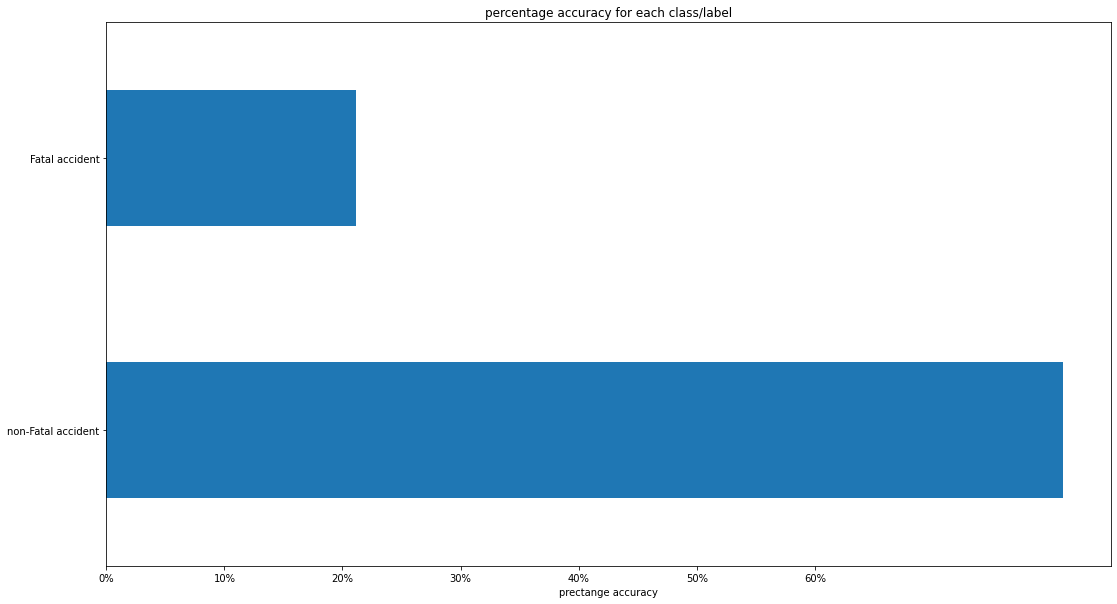

In [ ]:
#plot the accuracy of each labels predictions
fig, axes = plt.subplots(figsize=(18, 10))
accuracy.plot(kind='barh')
plt.yticks((0,1), ('non-Fatal accident', 'Fatal accident'))
plt.xticks((0,10,20,30,40,50,60), ('0%', '10%','20%','30%','40%','50%','60%'))
plt.xlabel('prectange accuracy')
plt.title('percentage accuracy for each class/label')

#Iteration 6 - 'Speed_limit'

##Features

###Seleceting Features, checking correlation between them, cleaning missing data

In [ ]:
df_features = df[['Speed_limit','Accident_Severity']]

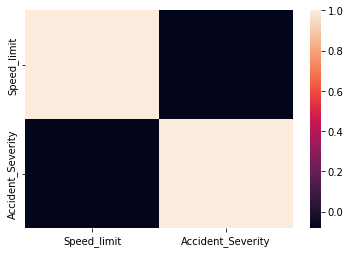

In [ ]:
#checking correlation between features
df_features.corr()
sns.heatmap(df_features.corr())

In [ ]:
#checking which values have missing data, note missing data is recorded as -1
df_features.min()

Speed_limit          0
Accident_Severity    1
dtype: int64

In [ ]:
#there are 161 accident that do not have recorded weather conditions, will drop these
#df_features['Weather_Conditions'][df_features['Weather_Conditions']==-1].count()

In [ ]:
#removing all rows with (missing) data
#df_features = df_features[df_features['Weather_Conditions']!=-1]
df_features = df_features[df_features['Speed_limit']!=0]

df_features.count()

### Cleaning Label (accident severity) so that there are 2 classes instead of 3

In [ ]:
#check count for each level of accident deverity
df_features['Accident_Severity'].value_counts()

3    1515574
2     242080
1      22998
Name: Accident_Severity, dtype: int64

In [ ]:
#replace all accident severities where severiry is 2 or 3 and group them into 1 bucket (non-fatal)
df_features['Accident_Severity'] = df_features['Accident_Severity'].replace(2,0)
df_features['Accident_Severity'] = df_features['Accident_Severity'].replace(3,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#create 2 dataframe, 1 for each class, and print the size each
class_1 = df_features[df_features['Accident_Severity'] == 1]
class_0 = df_features[df_features['Accident_Severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 22998
class 0 (non-fatal): 1757654


###Accounting for imbalance in the dataset by undersampling

In [ ]:
#get the length of the dataset for each class/label
class_count_0, class_count_1 = df_features['Accident_Severity'].value_counts()

In [ ]:
#undersampling of class 0 to balance the count of data for each class/label
class_0_under = class_0.sample(class_count_1)
df_features_under = pd.concat([class_0_under, class_1], axis=0)

In [ ]:
#print the size of the new dataset for each class/label after undersampling
class_1 = df_features_under[df_features_under['Accident_Severity'] == 1]
class_0 = df_features_under[df_features_under['Accident_Severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 22998
class 0 (non-fatal): 22998


###splitting the dataset in training and test datasets

In [ ]:
#splitting the dataset into training and test sets
train_features_under, test_features_under = train_test_split(df_features_under, test_size=0.25)

In [ ]:
#pop out the label column from the train and test undersampled datasets
train_label_under = train_features_under.pop('Accident_Severity')
test_label_under = test_features_under.pop('Accident_Severity')

## DNN Classifier

###defining input function, creating classifier, training classifer

In [ ]:
def input_fn(features, labels, training=True, batch_size=344):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

In [ ]:
# creating a tensorflow Feature column list
my_feature_columns = []
for key in train_features_under.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
my_feature_columns

[NumericColumn(key='Speed_limit', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 2 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpifot2p3s', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
classifier.train(input_fn=lambda: input_fn(train_features_under, train_label_under, training=True),steps=10000)
# We include a lambda to avoid creating an inner function 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpifot2p3s/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.459595, step = 0
INFO:tensorflow:global_step/sec: 344.895
INFO:tensorflow:loss = 0.6790743, step = 100 (0.298 sec)
INFO:tensorflow:global_step/sec: 450.191
INFO:tensorflow:loss = 0.68302155, step = 200 (0.220 sec)
INFO:tensorflow:global_step/sec: 433.884
INFO:tensorflow:loss = 0.6797348, step = 300 (0.227 sec)
INFO:tensorflow:global_step/sec: 470.087
INFO:tensorflow:loss = 0.68601114, step = 400 (0.215 sec)
INFO:tensorflow:global_step/sec: 466.079
INFO:tensorflow:loss = 0.67776775, step = 500 (0.212 sec)
INFO

###Evaluating Classifier

In [ ]:
#determine the accurracy of th classifier
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test_features_under, test_label_under, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-04-03T20:55:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpifot2p3s/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.67010s
INFO:tensorflow:Finished evaluation at 2022-04-03-20:55:52
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.66284025, accuracy_baseline = 0.50108707, auc = 0.6736135, auc_precision_recall = 0.64047086, average_loss = 0.6624384, global_step = 10000, label/mean = 0.50108707, loss = 0.6624635, precision = 0.66292137, prediction/mean = 0.53411937, recall = 0.6655675
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: /tmp/tmpifot2p3s/model.ckpt-10000

Test set accuracy: 0.663



In [ ]:
#create predictions list for all test set
predictions_under = list(classifier.predict(input_fn=lambda: input_fn(test_features_under, test_label_under, training=False)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpifot2p3s/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
#create a dataframe of predictions for test set
df_predictions = pd.DataFrame(predictions_under)

###Plot of Results

In [ ]:
#add the actual matches to the prediciton dataframe
df_predictions['actual label']=test_label_under.values

In [ ]:
#add the class predicitons from the DNN to the dataframe
df_predictions['predicted label']=pd.DataFrame.from_records(df_predictions['class_ids'])

In [ ]:
#add a binary column to show if the dnn predictions were correct
df_predictions['match?']=df_predictions['predicted label']-df_predictions['actual label']
df_predictions['match?']=df_predictions['match?'].replace(0,'match')
df_predictions['match?']=df_predictions['match?'].replace(-1,'not match')
df_predictions['match?']=df_predictions['match?'].replace(1,'not match')

In [ ]:
#view the prdictions dataframe
a=df_predictions[df_predictions['predicted label']==0]
a[a['actual label']==1]

,logits,logistic,probabilities,class_ids,classes,all_class_ids,all_classes,actual label,predicted label,match?,prob fatal,prob non-fatal
0,[-0.087412536],[0.47816077],"[0.52183926, 0.4781608]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match,0.478161,0.521839
7,[-0.087412536],[0.47816077],"[0.52183926, 0.4781608]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match,0.478161,0.521839
9,[-0.087412536],[0.47816077],"[0.52183926, 0.4781608]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match,0.478161,0.521839
11,[-0.087412536],[0.47816077],"[0.52183926, 0.4781608]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match,0.478161,0.521839
13,[-0.087412536],[0.47816077],"[0.52183926, 0.4781608]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match,0.478161,0.521839
...,...,...,...,...,...,...,...,...,...,...,...,...
11428,[-0.087412536],[0.47816077],"[0.52183926, 0.4781608]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match,0.478161,0.521839
11438,[-0.087412536],[0.47816077],"[0.52183926, 0.4781608]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match,0.478161,0.521839
11468,[-0.087412536],[0.47816077],"[0.52183926, 0.4781608]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match,0.478161,0.521839
11486,[-0.087412536],[0.47816077],"[0.52183926, 0.4781608]",[0],[b'0'],"[0, 1]","[b'0', b'1']",1,0,not match,0.478161,0.521839


In [ ]:
#create a new dataframe showing only the correct predictions
correct_predictions = df_predictions[df_predictions['match?']=='match']
#get the count of the correct predctions for eah label
correct_pred_count_label_0 , correct_pred_count_label_1 = correct_predictions['predicted label'].value_counts()
#get the actual label count for each label
actual_count_label_0 , actual_count_label_1 = df_predictions['actual label'].value_counts()

In [ ]:
#get the accuracy of each labels predictions
accuracy_label_0,accuracy_label_1 = correct_pred_count_label_0/actual_count_label_0 , correct_pred_count_label_1/actual_count_label_1
accuracy=accuracy_label_0*100,accuracy_label_1*100
accuracy=pd.Series(accuracy)
print('Accuracy of label 0 (non-fatal): ', accuracy_label_0, '\nAccuracy of label 1 (fatal): ', accuracy_label_1)

Accuracy of label 0 (non-fatal):  0.6655675112808053 
Accuracy of label 1 (fatal):  0.6601010981349137


Text(0.5, 1.0, 'percentage accuracy for each class/label')

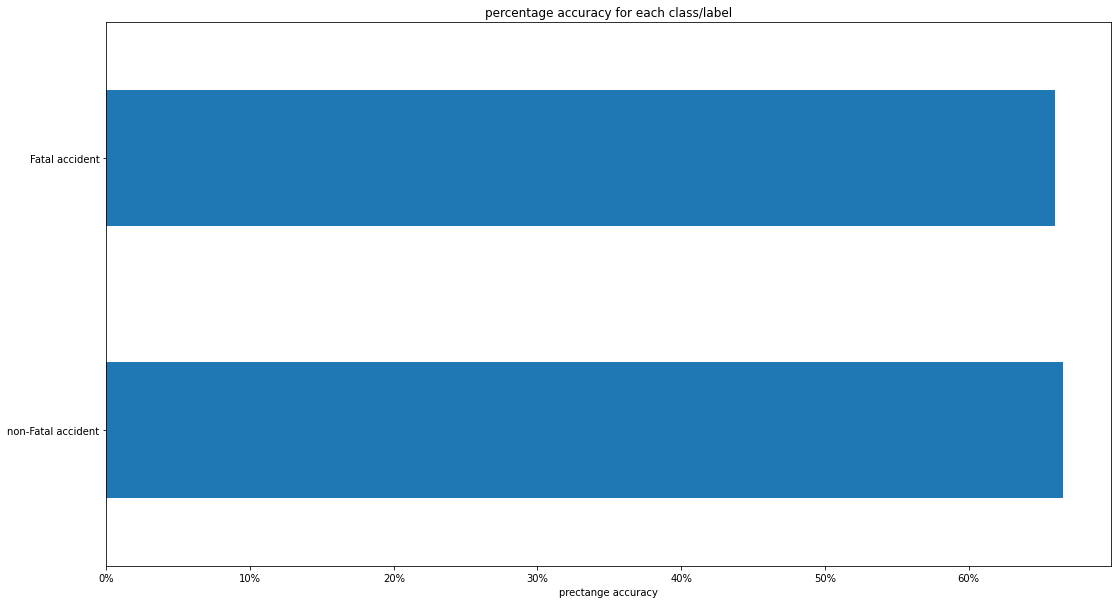

In [ ]:
#plot the accuracy of each labels predictions
fig, axes = plt.subplots(figsize=(18, 10))
accuracy.plot(kind='barh')
plt.yticks((0,1), ('non-Fatal accident', 'Fatal accident'))
plt.xticks((0,10,20,30,40,50,60), ('0%', '10%','20%','30%','40%','50%','60%'))
plt.xlabel('prectange accuracy')
plt.title('percentage accuracy for each class/label')

#Iteration 7 - 'Speed_limit', 'district'

##Features

###Seleceting Features, checking correlation between them, cleaning missing data

In [ ]:
df_features = df[['Speed_limit', 'Local_Authority_(District)','Accident_Severity']]
df_features = df_features.rename(columns={'Local_Authority_(District)':'district'})

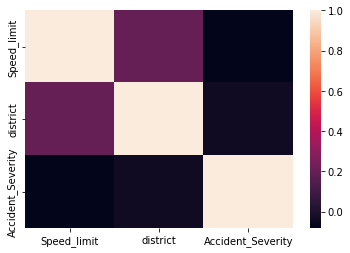

In [ ]:
#checking correlation between features
df_features.corr()
sns.heatmap(df_features.corr())

In [ ]:
#checking which values have missing data, note missing data is recorded as -1
df_features.min()

Speed_limit          0
district             1
Accident_Severity    1
dtype: int64

In [ ]:
#there are 161 accident that do not have recorded weather conditions, will drop these
#df_features['Weather_Conditions'][df_features['Weather_Conditions']==-1].count()

In [ ]:
#removing all rows with (missing) data
#df_features = df_features[df_features['Weather_Conditions']!=-1]
df_features = df_features[df_features['Speed_limit']!=0]

df_features.count()

### Cleaning Label (accident severity) so that there are 2 classes instead of 3

In [ ]:
#check count for each level of accident deverity
df_features['Accident_Severity'].value_counts()

3    1515574
2     242080
1      22998
Name: Accident_Severity, dtype: int64

In [ ]:
#replace all accident severities where severiry is 2 or 3 and group them into 1 bucket (non-fatal)
df_features['Accident_Severity'] = df_features['Accident_Severity'].replace(2,0)
df_features['Accident_Severity'] = df_features['Accident_Severity'].replace(3,0)

In [ ]:
#create 2 dataframe, 1 for each class, and print the size each
class_1 = df_features[df_features['Accident_Severity'] == 1]
class_0 = df_features[df_features['Accident_Severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 22998
class 0 (non-fatal): 1757654


###Accounting for imbalance in the dataset by undersampling

In [ ]:
#get the length of the dataset for each class/label
class_count_0, class_count_1 = df_features['Accident_Severity'].value_counts()

In [ ]:
#undersampling of class 0 to balance the count of data for each class/label
class_0_under = class_0.sample(class_count_1)
df_features_under = pd.concat([class_0_under, class_1], axis=0)

In [ ]:
#print the size of the new dataset for each class/label after undersampling
class_1 = df_features_under[df_features_under['Accident_Severity'] == 1]
class_0 = df_features_under[df_features_under['Accident_Severity'] == 0]
print('class 1 (fatal):', len(class_1))
print('class 0 (non-fatal):', len(class_0))

class 1 (fatal): 22998
class 0 (non-fatal): 22998


###splitting the dataset in training and test datasets

In [ ]:
#splitting the dataset into training and test sets
train_features_under, test_features_under = train_test_split(df_features_under, test_size=0.25)

In [ ]:
#pop out the label column from the train and test undersampled datasets
train_label_under = train_features_under.pop('Accident_Severity')
test_label_under = test_features_under.pop('Accident_Severity')

## DNN Classifier

###defining input function, creating classifier, training classifer

In [ ]:
def input_fn(features, labels, training=True, batch_size=344):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    return dataset.batch(batch_size)

In [ ]:
# creating a tensorflow Feature column list
my_feature_columns = []
for key in train_features_under.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
my_feature_columns

[NumericColumn(key='Speed_limit', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='district', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 2 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp25z9i_ud', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
classifier.train(input_fn=lambda: input_fn(train_features_under, train_label_under, training=True),steps=2000)
# We include a lambda to avoid creating an inner function 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp25z9i_ud/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 3.8365319, step = 0
INFO:tensorflow:global_step/sec: 406.495
INFO:tensorflow:loss = 0.66069525, step = 100 (0.250 sec)
INFO:tensorflow:global_step/sec: 523.466
INFO:tensorflow:loss = 0.66006166, step = 200 (0.192 sec)
INFO:tensorflow:global_step/sec: 536.433
INFO:tensorflow:loss = 0.6899964, step = 300 (0.185 sec)
INFO:tensorflow:global_step/sec: 496.934
INFO:tensorflow:loss = 0.6934933, step = 400 (0.202 sec)
INFO:tensorflow:global_step/sec: 527.723
INFO:tensorflow:loss = 0.70491016, step = 500 (0.189 sec)
INF

###Evaluating Classifier

In [ ]:
#determine the accurracy of th classifier
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test_features_under, test_label_under, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-03-26T16:57:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp25z9i_ud/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.49457s
INFO:tensorflow:Finished evaluation at 2022-03-26-16:57:52
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.59474736, accuracy_baseline = 0.5001305, auc = 0.65455943, auc_precision_recall = 0.62742674, average_loss = 0.6670738, global_step = 2000, label/mean = 0.5001305, loss = 0.6669917, precision = 0.5669243, prediction/mean = 0.5293427, recall = 0.80351245
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp25z9i_ud/model.ckpt-2000

Test set accuracy: 0.595



In [ ]:
#create predictions list for all test set
predictions_under = list(classifier.predict(input_fn=lambda: input_fn(test_features_under, test_label_under, training=False)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp25z9i_ud/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
#create a dataframe of predictions for test set
df_predictions = pd.DataFrame(predictions_under)

###Plot of Results

In [ ]:
#add the actual matches to the prediciton dataframe
df_predictions['actual label']=test_label_under.values

In [ ]:
#add the class predicitons from the DNN to the dataframe
df_predictions['predicted label']=pd.DataFrame.from_records(df_predictions['class_ids'])

In [ ]:
#add a binary column to show if the dnn predictions were correct
df_predictions['match?']=df_predictions['predicted label']-df_predictions['actual label']
df_predictions['match?']=df_predictions['match?'].replace(0,'match')
df_predictions['match?']=df_predictions['match?'].replace(-1,'not match')
df_predictions['match?']=df_predictions['match?'].replace(1,'not match')

In [ ]:
#view the prdictions dataframe
df_predictions.head()

,logits,logistic,probabilities,class_ids,classes,all_class_ids,all_classes,actual label,predicted label,match?
0,[0.4801847],[0.6177915],"[0.38220853, 0.6177915]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match
1,[0.40348163],[0.59952384],"[0.40047613, 0.59952384]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
2,[0.6813613],[0.6640425],"[0.33595756, 0.6640425]",[1],[b'1'],"[0, 1]","[b'0', b'1']",1,1,match
3,[0.5923518],[0.64390457],"[0.3560954, 0.64390457]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match
4,[0.15346965],[0.5382923],"[0.4617077, 0.5382923]",[1],[b'1'],"[0, 1]","[b'0', b'1']",0,1,not match


In [ ]:
#create a new dataframe showing only the correct predictions
correct_predictions = df_predictions[df_predictions['match?']=='match']
#get the count of the correct predctions for eah label
correct_pred_count_label_0 , correct_pred_count_label_1 = correct_predictions['predicted label'].value_counts()
#get the actual label count for each label
actual_count_label_0 , actual_count_label_1 = df_predictions['actual label'].value_counts()

In [ ]:
#get the accuracy of each labels predictions
accuracy_label_0,accuracy_label_1 = correct_pred_count_label_0/actual_count_label_0 , correct_pred_count_label_1/actual_count_label_1
accuracy=accuracy_label_0*100,accuracy_label_1*100
accuracy=pd.Series(accuracy)
print('Accuracy of label 0 (non-fatal): ', accuracy_label_0, '\nAccuracy of label 1 (fatal): ', accuracy_label_1)

Accuracy of label 0 (non-fatal):  0.8035124326204138 
Accuracy of label 1 (fatal):  0.3858733472512178


Text(0.5, 1.0, 'percentage accuracy for each class/label')

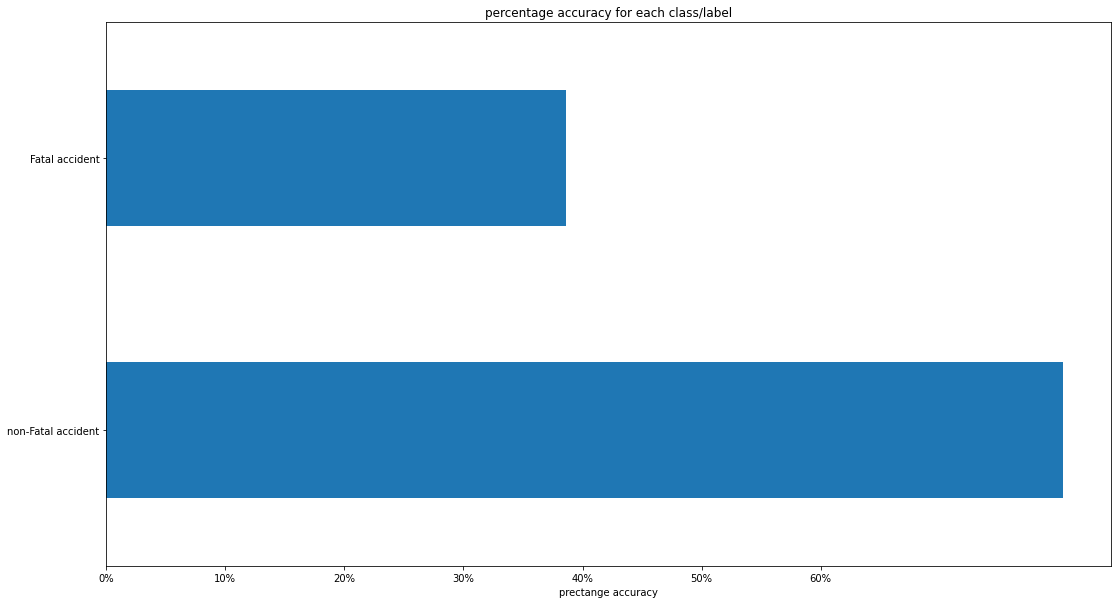

In [ ]:
#plot the accuracy of each labels predictions
fig, axes = plt.subplots(figsize=(18, 10))
accuracy.plot(kind='barh')
plt.yticks((0,1), ('non-Fatal accident', 'Fatal accident'))
plt.xticks((0,10,20,30,40,50,60), ('0%', '10%','20%','30%','40%','50%','60%'))
plt.xlabel('prectange accuracy')
plt.title('percentage accuracy for each class/label')